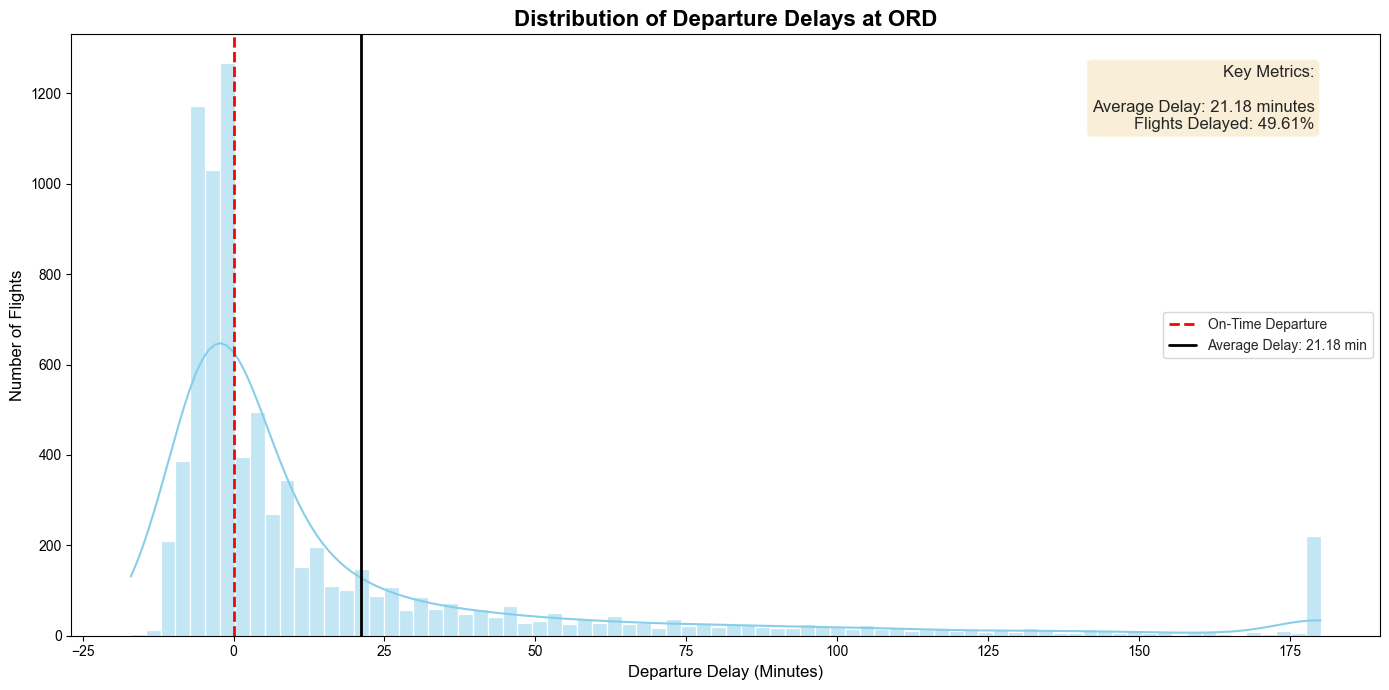

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

flight_data = pd.read_csv('Flight Level Data.csv')

flight_data['scheduled_departure_datetime_local'] = pd.to_datetime(flight_data['scheduled_departure_datetime_local'], errors='coerce')
flight_data['actual_departure_datetime_local'] = pd.to_datetime(flight_data['actual_departure_datetime_local'], errors='coerce')
flight_data.dropna(subset=['scheduled_departure_datetime_local', 'actual_departure_datetime_local'], inplace=True)
flight_data['departure_delay_minutes'] = (flight_data['actual_departure_datetime_local'] - flight_data['scheduled_departure_datetime_local']).dt.total_seconds() / 60

average_delay = flight_data['departure_delay_minutes'].mean()
delayed_flights = flight_data[flight_data['departure_delay_minutes'] > 0]
percentage_delayed = (len(delayed_flights) / len(flight_data)) * 100

fig, ax = plt.subplots(figsize=(14, 7))
sns.set_style("whitegrid")

sns.histplot(flight_data['departure_delay_minutes'].clip(-60, 180), bins=80, kde=True, ax=ax, color='skyblue')
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='On-Time Departure')
ax.axvline(average_delay, color='black', linestyle='-', linewidth=2, label=f'Average Delay: {average_delay:.2f} min')

ax.set_title('Distribution of Departure Delays at ORD', fontsize=16, fontweight='bold')
ax.set_xlabel('Departure Delay (Minutes)', fontsize=12)
ax.set_ylabel('Number of Flights', fontsize=12)
ax.legend()

kpi_text = f"Key Metrics:\n\n" \
           f"Average Delay: {average_delay:.2f} minutes\n" \
           f"Flights Delayed: {percentage_delayed:.2f}%"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.95, 0.95, kpi_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.show()


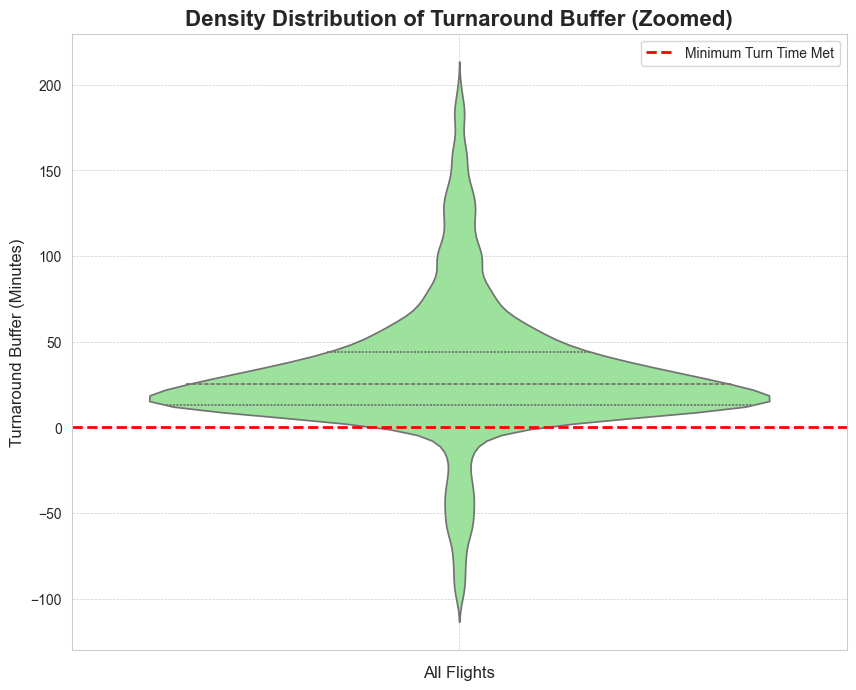


     Summary of Turnaround Buffer Analysis
                            Statistic    Value
               Total Flights Analyzed    8,099
                Mean Buffer (minutes)   135.75
      Median Buffer (50th Percentile)    29.00
                   Standard Deviation   562.91
                      25th Percentile    14.00
                      75th Percentile    64.00
             Minimum Buffer (minutes) -1009.00
             Maximum Buffer (minutes) 33281.00
Flights At or Below Minimum Turn Time    8.05%


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

flight_data = pd.read_csv('Flight Level Data.csv')

flight_data['scheduled_ground_time_minutes'] = pd.to_numeric(
    flight_data['scheduled_ground_time_minutes'], errors='coerce'
)
flight_data['minimum_turn_minutes'] = pd.to_numeric(
    flight_data['minimum_turn_minutes'], errors='coerce'
)

cleaned_data = flight_data.dropna(
    subset=['scheduled_ground_time_minutes', 'minimum_turn_minutes']
).copy()

cleaned_data['turnaround_buffer_minutes'] = (
    cleaned_data['scheduled_ground_time_minutes'] - cleaned_data['minimum_turn_minutes']
)

sns.set_style('whitegrid')
plt.figure(figsize=(10, 8))

zoom_data = cleaned_data[(cleaned_data['turnaround_buffer_minutes'] >= -100) & (cleaned_data['turnaround_buffer_minutes'] <= 200)]

sns.violinplot(y=zoom_data['turnaround_buffer_minutes'], color='lightgreen', inner='quartile')

plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Minimum Turn Time Met')

plt.title('Density Distribution of Turnaround Buffer (Zoomed)', fontsize=16, fontweight='bold')
plt.ylabel('Turnaround Buffer (Minutes)', fontsize=12)
plt.xlabel('All Flights', fontsize=12)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

stats = cleaned_data['turnaround_buffer_minutes'].describe()
risky_flights_count = (cleaned_data['turnaround_buffer_minutes'] <= 0).sum()
total_flights_count = len(cleaned_data)
percentage_risky = (risky_flights_count / total_flights_count) * 100

summary_data = {
    'Statistic': [
        'Total Flights Analyzed',
        'Mean Buffer (minutes)',
        'Median Buffer (50th Percentile)',
        'Standard Deviation',
        '25th Percentile',
        '75th Percentile',
        'Minimum Buffer (minutes)',
        'Maximum Buffer (minutes)',
        'Flights At or Below Minimum Turn Time'
    ],
    'Value': [
        f"{int(stats['count']):,}",
        f"{stats['mean']:.2f}",
        f"{stats['50%']:.2f}",
        f"{stats['std']:.2f}",
        f"{stats['25%']:.2f}",
        f"{stats['75%']:.2f}",
        f"{stats['min']:.2f}",
        f"{stats['max']:.2f}",
        f"{percentage_risky:.2f}%"
    ]
}
summary_df = pd.DataFrame(summary_data)

print("\n" + "="*50)
print("     Summary of Turnaround Buffer Analysis")
print("="*50)
print(summary_df.to_string(index=False))
print("="*50)



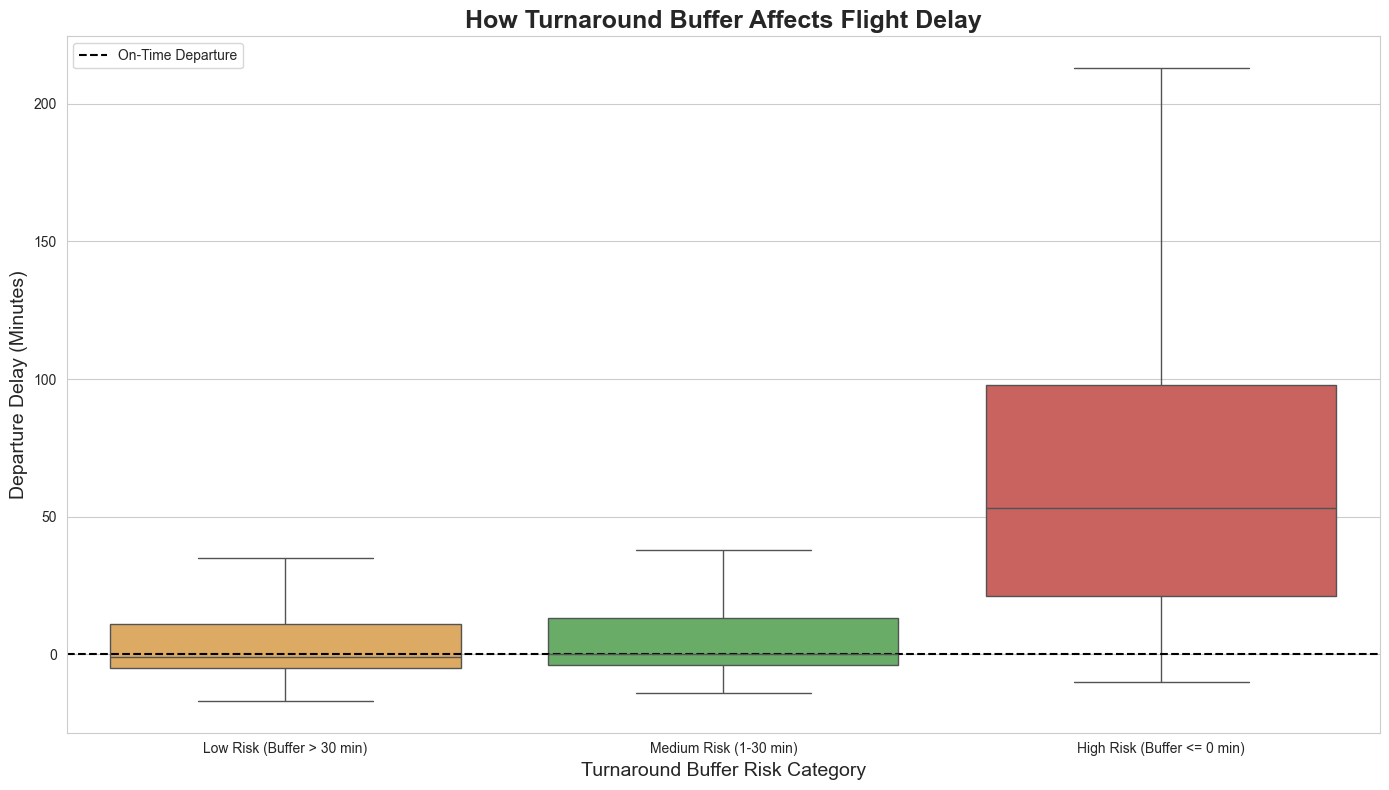

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

flight_data = pd.read_csv('Flight Level Data.csv')

flight_data['scheduled_departure_datetime_local'] = pd.to_datetime(flight_data['scheduled_departure_datetime_local'], errors='coerce')
flight_data['actual_departure_datetime_local'] = pd.to_datetime(flight_data['actual_departure_datetime_local'], errors='coerce')
flight_data.dropna(subset=['scheduled_departure_datetime_local', 'actual_departure_datetime_local'], inplace=True)

flight_data['departure_delay_minutes'] = (flight_data['actual_departure_datetime_local'] - flight_data['scheduled_departure_datetime_local']).dt.total_seconds() / 60

flight_data.dropna(subset=['scheduled_ground_time_minutes', 'minimum_turn_minutes'], inplace=True)
flight_data['turnaround_buffer'] = flight_data['scheduled_ground_time_minutes'] - flight_data['minimum_turn_minutes']

def categorize_buffer_risk(buffer):
    if buffer <= 0:
        return 'High Risk (Buffer <= 0 min)'
    elif buffer <= 30:
        return 'Medium Risk (1-30 min)'
    else:
        return 'Low Risk (Buffer > 30 min)'

plot_data = flight_data[flight_data['departure_delay_minutes'].between(-60, 400)].copy()
plot_data['buffer_risk_category'] = plot_data['turnaround_buffer'].apply(categorize_buffer_risk)

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

category_order = ['Low Risk (Buffer > 30 min)', 'Medium Risk (1-30 min)', 'High Risk (Buffer <= 0 min)']
palette_list = ['#5cb85c', '#f0ad4e', '#d9534f']

sns.boxplot(
    data=plot_data,
    x='buffer_risk_category',
    y='departure_delay_minutes',
    order=category_order,
    palette=palette_list,
    hue='buffer_risk_category',
    legend=False,
    showfliers=False  
)

plt.title('How Turnaround Buffer Affects Flight Delay', fontsize=18, fontweight='bold')
plt.xlabel('Turnaround Buffer Risk Category', fontsize=14)
plt.ylabel('Departure Delay (Minutes)', fontsize=14)
plt.axhline(0, color='black', linestyle='--', linewidth=1.5, label='On-Time Departure')
plt.legend()
plt.tight_layout()
plt.show()


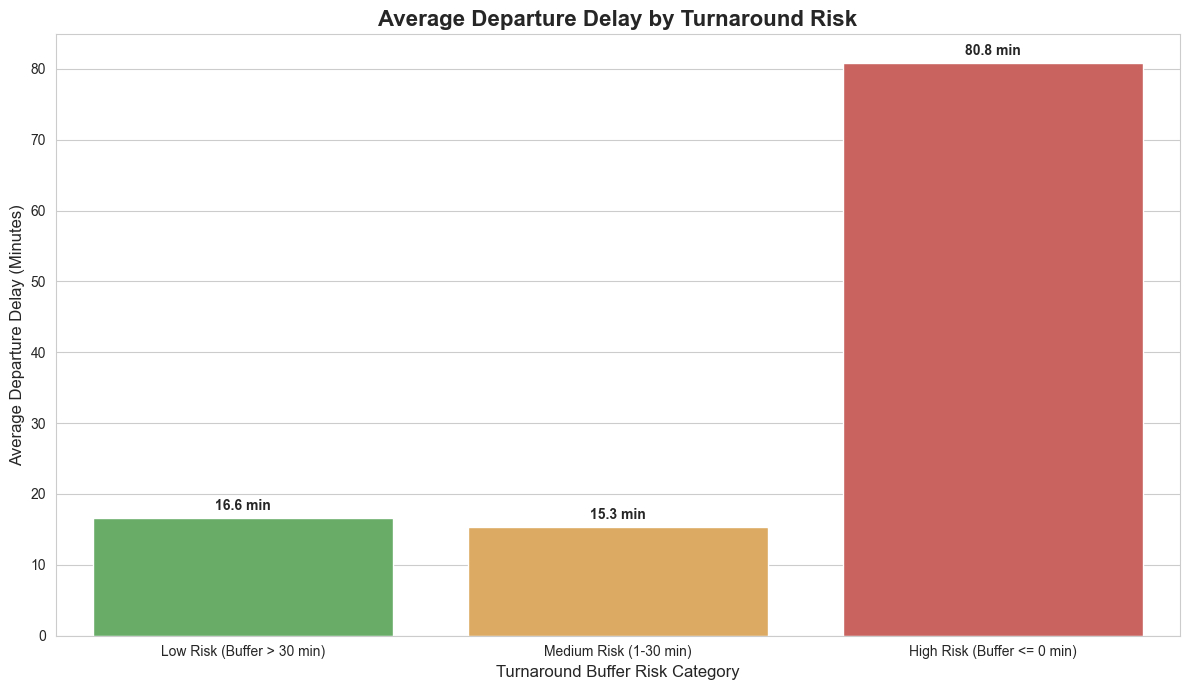

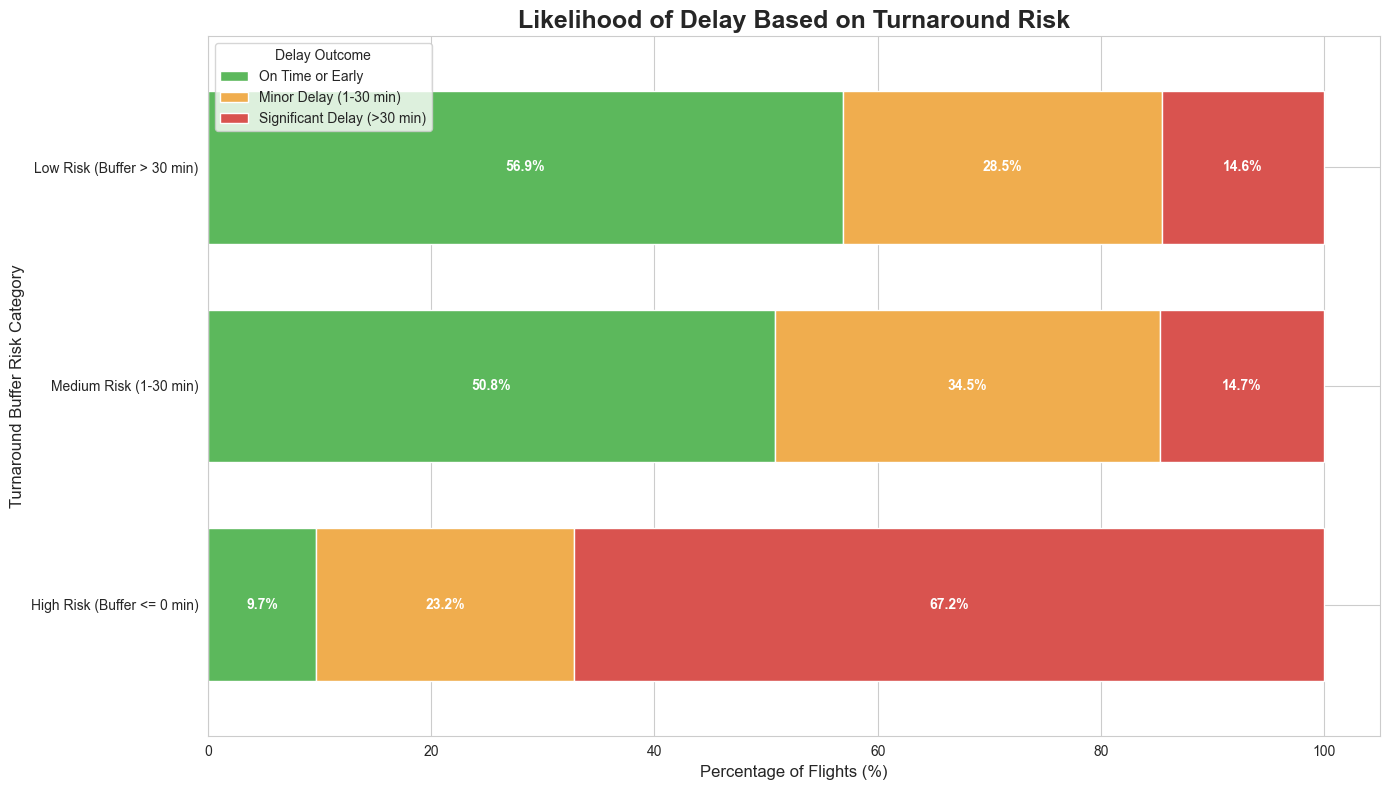

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

flight_data = pd.read_csv('Flight Level Data.csv')

flight_data['scheduled_departure_datetime_local'] = pd.to_datetime(flight_data['scheduled_departure_datetime_local'], errors='coerce')
flight_data['actual_departure_datetime_local'] = pd.to_datetime(flight_data['actual_departure_datetime_local'], errors='coerce')
flight_data.dropna(subset=['scheduled_departure_datetime_local', 'actual_departure_datetime_local'], inplace=True)
flight_data['departure_delay_minutes'] = (flight_data['actual_departure_datetime_local'] - flight_data['scheduled_departure_datetime_local']).dt.total_seconds() / 60
flight_data.dropna(subset=['scheduled_ground_time_minutes', 'minimum_turn_minutes'], inplace=True)
flight_data['turnaround_buffer'] = flight_data['scheduled_ground_time_minutes'] - flight_data['minimum_turn_minutes']
plot_data = flight_data.copy()

def categorize_buffer_risk(buffer):
    if buffer <= 0:
        return 'High Risk (Buffer <= 0 min)'
    elif buffer <= 30:
        return 'Medium Risk (1-30 min)'
    else:
        return 'Low Risk (Buffer > 30 min)'
plot_data['buffer_risk_category'] = plot_data['turnaround_buffer'].apply(categorize_buffer_risk)
category_order = ['Low Risk (Buffer > 30 min)', 'Medium Risk (1-30 min)', 'High Risk (Buffer <= 0 min)']

avg_delay_data = plot_data.groupby('buffer_risk_category')['departure_delay_minutes'].mean().reindex(category_order).reset_index()
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")
ax = sns.barplot(
    data=avg_delay_data,
    x='buffer_risk_category',
    y='departure_delay_minutes',
    palette={'Low Risk (Buffer > 30 min)': '#5cb85c', 'Medium Risk (1-30 min)': '#f0ad4e', 'High Risk (Buffer <= 0 min)': '#d9534f'},
    hue='buffer_risk_category',
    legend=False
)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f} min', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontweight='bold')
plt.title('Average Departure Delay by Turnaround Risk', fontsize=16, fontweight='bold')
plt.xlabel('Turnaround Buffer Risk Category', fontsize=12)
plt.ylabel('Average Departure Delay (Minutes)', fontsize=12)
plt.tight_layout()
plt.show()

def categorize_delay(delay):
    if delay <= 0:
        return 'On Time or Early'
    elif delay <= 30:
        return 'Minor Delay (1-30 min)'
    else:
        return 'Significant Delay (>30 min)'
plot_data['delay_outcome'] = plot_data['departure_delay_minutes'].apply(categorize_delay)

outcome_distribution = plot_data.groupby(['buffer_risk_category', 'delay_outcome']).size().unstack(fill_value=0)
outcome_percentage = outcome_distribution.apply(lambda x: x / x.sum() * 100, axis=1).reindex(category_order)
delay_order = ['On Time or Early', 'Minor Delay (1-30 min)', 'Significant Delay (>30 min)']
outcome_percentage = outcome_percentage[delay_order]

outcome_percentage.plot(
    kind='barh',
    stacked=True,
    figsize=(14, 8),
    color=['#5cb85c', '#f0ad4e', '#d9534f'],
    width=0.7
)
plt.title('Likelihood of Delay Based on Turnaround Risk', fontsize=18, fontweight='bold')
plt.xlabel('Percentage of Flights (%)', fontsize=12)
plt.ylabel('Turnaround Buffer Risk Category', fontsize=12)
plt.legend(title='Delay Outcome')
plt.gca().invert_yaxis()
for index, row in enumerate(outcome_percentage.itertuples()):
    cum_width = 0
    for i, value in enumerate(row[1:]):
        if value > 5:
            plt.text(cum_width + value / 2, index, f'{value:.1f}%', ha='center', va='center', color='white', fontweight='bold')
        cum_width += value
plt.tight_layout()
plt.show()




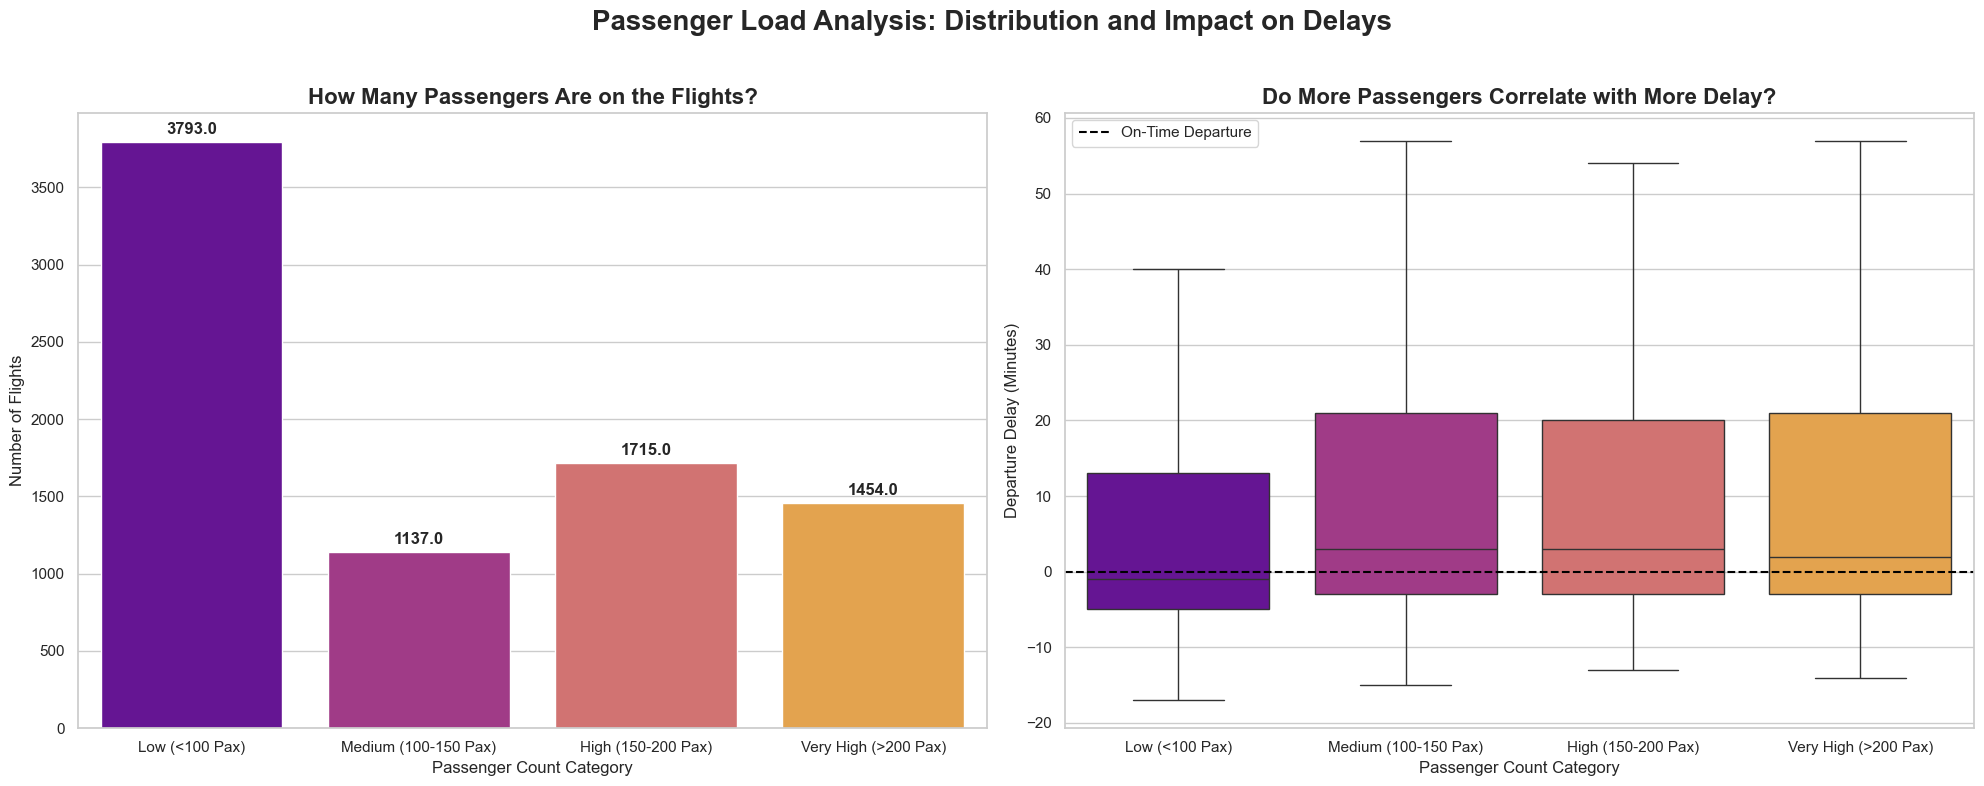

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

flight_data = pd.read_csv('Flight Level Data.csv')
pnr_flight_data = pd.read_csv('PNR Flight Level Data.csv')

def create_flight_key(df):
    date_col = 'scheduled_departure_date_local'
    df[date_col] = pd.to_datetime(df[date_col]).dt.date
    return (df[date_col].astype(str) + '_' +
            df['flight_number'].astype(str) + '_' +
            df['scheduled_departure_station_code'].astype(str))

flight_data['flight_key'] = create_flight_key(flight_data)
pnr_flight_data['flight_key'] = create_flight_key(pnr_flight_data)

pax_counts = pnr_flight_data.groupby('flight_key')['total_pax'].sum().reset_index()
analysis_df = pd.merge(flight_data, pax_counts, on='flight_key', how='inner')

analysis_df['scheduled_departure_datetime_local'] = pd.to_datetime(analysis_df['scheduled_departure_datetime_local'], errors='coerce')
analysis_df['actual_departure_datetime_local'] = pd.to_datetime(analysis_df['actual_departure_datetime_local'], errors='coerce')
analysis_df.dropna(subset=['scheduled_departure_datetime_local', 'actual_departure_datetime_local'], inplace=True)
analysis_df['departure_delay_minutes'] = (analysis_df['actual_departure_datetime_local'] - analysis_df['scheduled_departure_datetime_local']).dt.total_seconds() / 60

analysis_df['passenger_category'] = pd.cut(
    analysis_df['total_pax'],
    bins=[0, 100, 150, 200, analysis_df['total_pax'].max()],
    labels=['Low (<100 Pax)', 'Medium (100-150 Pax)', 'High (150-200 Pax)', 'Very High (>200 Pax)']
)
analysis_df.dropna(subset=['passenger_category'], inplace=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
sns.set_theme(style="whitegrid")
fig.suptitle('Passenger Load Analysis: Distribution and Impact on Delays', fontsize=20, fontweight='bold')

category_order = ['Low (<100 Pax)', 'Medium (100-150 Pax)', 'High (150-200 Pax)', 'Very High (>200 Pax)']
ax1 = sns.countplot(
    data=analysis_df,
    x='passenger_category',
    order=category_order,
    ax=axes[0],
    palette='plasma',
    hue='passenger_category',
    legend=False
)
ax1.set_title('How Many Passengers Are on the Flights?', fontsize=16, fontweight='bold')
ax1.set_xlabel('Passenger Count Category', fontsize=12)
ax1.set_ylabel('Number of Flights', fontsize=12)
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontweight='bold')

plot_data = analysis_df[analysis_df['departure_delay_minutes'].between(-60, 400)]
ax2 = sns.boxplot(
    data=plot_data,
    x='passenger_category',
    y='departure_delay_minutes',
    order=category_order,
    ax=axes[1],
    palette='plasma',
    showfliers=False,
    hue='passenger_category',
    legend=False
)
ax2.set_title('Do More Passengers Correlate with More Delay?', fontsize=16, fontweight='bold')
ax2.set_xlabel('Passenger Count Category', fontsize=12)
ax2.set_ylabel('Departure Delay (Minutes)', fontsize=12)
ax2.axhline(0, color='black', linestyle='--', linewidth=1.5, label='On-Time Departure')
ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()




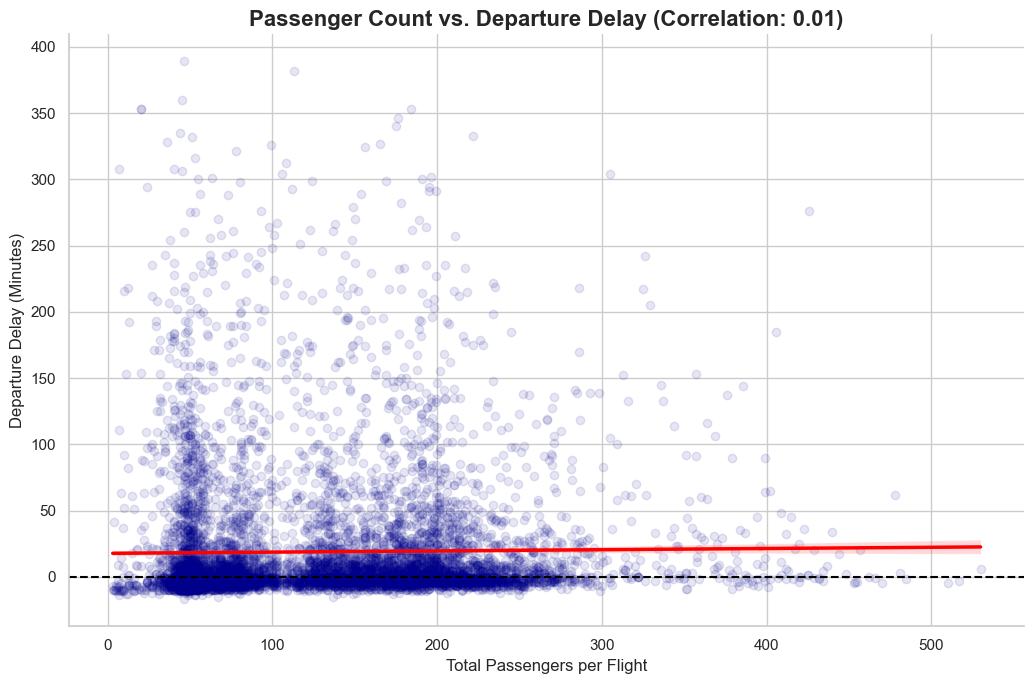

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

flight_data = pd.read_csv('Flight Level Data.csv')
pnr_flight_data = pd.read_csv('PNR Flight Level Data.csv')

def create_flight_key(df):
    date_col = 'scheduled_departure_date_local'
    df[date_col] = pd.to_datetime(df[date_col]).dt.date
    return (df[date_col].astype(str) + '_' +
            df['flight_number'].astype(str) + '_' +
            df['scheduled_departure_station_code'].astype(str))

flight_data['flight_key'] = create_flight_key(flight_data)
pnr_flight_data['flight_key'] = create_flight_key(pnr_flight_data)

flight_data['scheduled_departure_datetime_local'] = pd.to_datetime(flight_data['scheduled_departure_datetime_local'], errors='coerce')
flight_data['actual_departure_datetime_local'] = pd.to_datetime(flight_data['actual_departure_datetime_local'], errors='coerce')
flight_data.dropna(subset=['scheduled_departure_datetime_local', 'actual_departure_datetime_local'], inplace=True)
flight_data['delay'] = (flight_data['actual_departure_datetime_local'] - flight_data['scheduled_departure_datetime_local']).dt.total_seconds() / 60

pax_counts = pnr_flight_data.groupby('flight_key')['total_pax'].sum().reset_index()

merged_df = pd.merge(flight_data, pax_counts, on='flight_key', how='inner')

plot_df = merged_df[merged_df['delay'].between(-60, 400)].dropna(subset=['total_pax', 'delay'])

corr = plot_df['total_pax'].corr(plot_df['delay'])

sns.lmplot(data=plot_df, x='total_pax', y='delay', height=7, aspect=1.5,
           scatter_kws={'alpha': 0.1, 'color': 'darkblue'},
           line_kws={'color': 'red', 'linewidth': 2.5})

plt.title(f'Passenger Count vs. Departure Delay (Correlation: {corr:.2f})', fontsize=16, fontweight='bold')
plt.xlabel('Total Passengers per Flight', fontsize=12)
plt.ylabel('Departure Delay (Minutes)', fontsize=12)
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


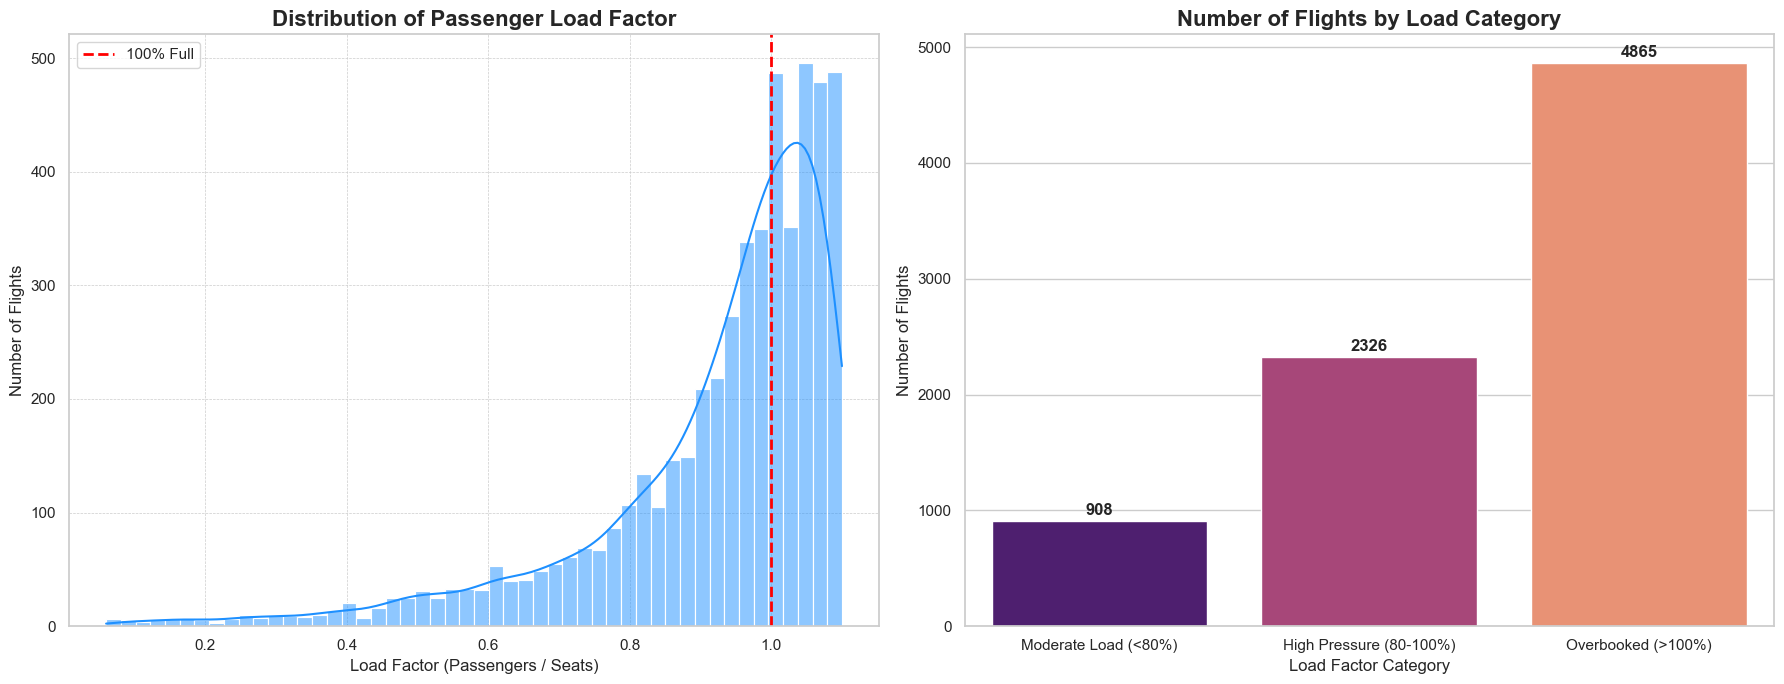

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pnr_data = pd.read_csv('PNR Flight Level Data.csv')
flight_data = pd.read_csv('Flight Level Data.csv')

flight_identifier_cols = [
    'company_id', 'flight_number', 'scheduled_departure_date_local',
    'scheduled_departure_station_code', 'scheduled_arrival_station_code'
]

passenger_counts = pnr_data.groupby(flight_identifier_cols)['total_pax'].sum().reset_index()
passenger_counts.rename(columns={'total_pax': 'total_passengers'}, inplace=True)

merged_data = pd.merge(
    flight_data,
    passenger_counts,
    on=flight_identifier_cols,
    how='inner'
)

merged_data = merged_data[merged_data['total_seats'] > 0].copy()

merged_data['load_factor'] = merged_data['total_passengers'] / merged_data['total_seats']

hist_data = merged_data[merged_data['load_factor'] <= 1.1].copy()

def assign_load_category(factor):
    if factor > 1.0:
        return 'Overbooked (>100%)'
    elif factor >= 0.8:
        return 'High Pressure (80-100%)'
    else:
        return 'Moderate Load (<80%)'

merged_data['load_category'] = merged_data['load_factor'].apply(assign_load_category)

category_order = ['Moderate Load (<80%)', 'High Pressure (80-100%)', 'Overbooked (>100%)']
category_counts = merged_data['load_category'].value_counts().reindex(category_order)

sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.histplot(hist_data['load_factor'], bins=50, kde=True, color='dodgerblue', ax=axes[0])
axes[0].axvline(1.0, color='red', linestyle='--', linewidth=2, label='100% Full')
axes[0].set_title('Distribution of Passenger Load Factor', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Load Factor (Passengers / Seats)', fontsize=12)
axes[0].set_ylabel('Number of Flights', fontsize=12)
axes[0].legend()
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)

sns.barplot(
    x=category_counts.index,
    y=category_counts.values,
    palette='magma',
    hue=category_counts.index,
    legend=False,
    ax=axes[1]
)
axes[1].set_title('Number of Flights by Load Category', fontsize=16, fontweight='bold')
axes[1].set_ylabel('Number of Flights', fontsize=12)
axes[1].set_xlabel('Load Factor Category', fontsize=12)

for i, count in enumerate(category_counts.values):
    axes[1].text(i, count + 50, str(count), ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()



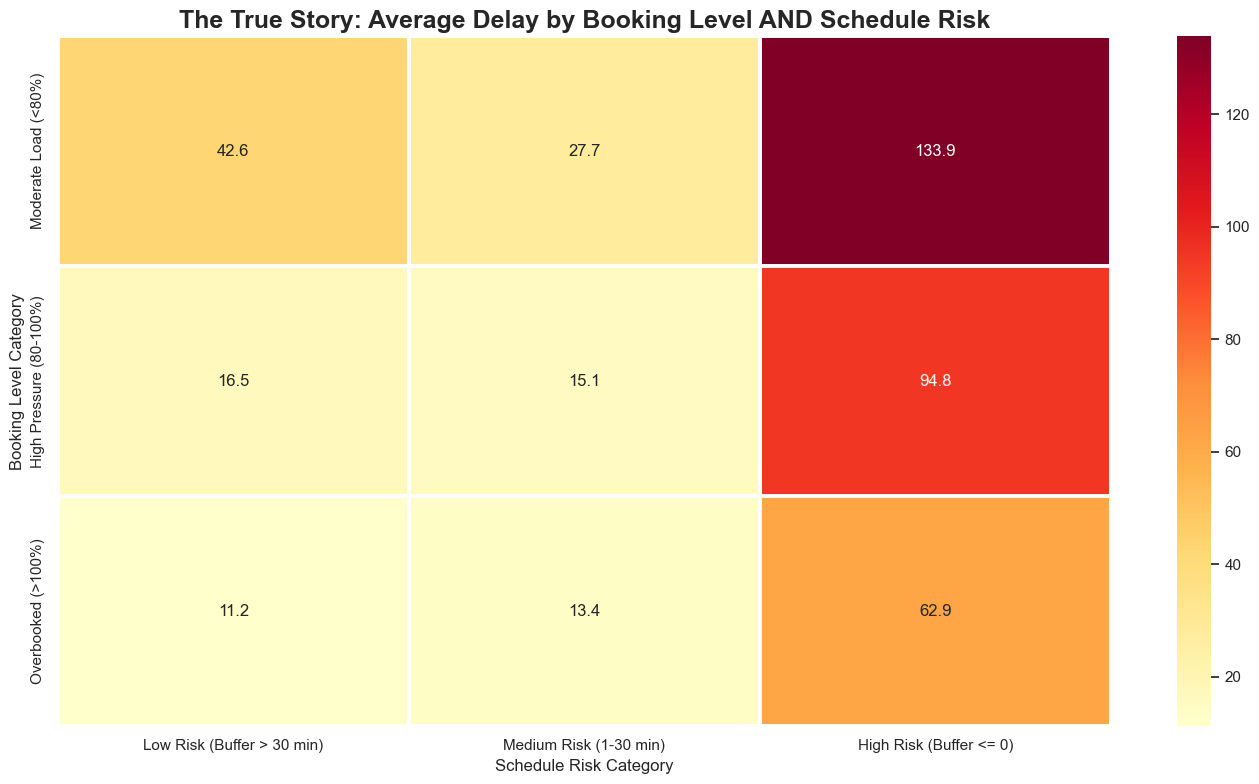

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

flight_data = pd.read_csv('Flight Level Data.csv')
pnr_flight_data = pd.read_csv('PNR Flight Level Data.csv')

def create_flight_key(df):
    date_col = 'scheduled_departure_date_local'
    df[date_col] = pd.to_datetime(df[date_col]).dt.date
    return (df[date_col].astype(str) + '_' +
            df['flight_number'].astype(str) + '_' +
            df['scheduled_departure_station_code'].astype(str))

for df in [flight_data, pnr_flight_data]:
    df['flight_key'] = create_flight_key(df)

flight_data['scheduled_departure_datetime_local'] = pd.to_datetime(flight_data['scheduled_departure_datetime_local'], errors='coerce')
flight_data['actual_departure_datetime_local'] = pd.to_datetime(flight_data['actual_departure_datetime_local'], errors='coerce')
flight_data.dropna(subset=['scheduled_departure_datetime_local', 'actual_departure_datetime_local'], inplace=True)
flight_data['departure_delay_minutes'] = (flight_data['actual_departure_datetime_local'] - flight_data['scheduled_departure_datetime_local']).dt.total_seconds() / 60

flight_data.dropna(subset=['scheduled_ground_time_minutes', 'minimum_turn_minutes'], inplace=True)
flight_data['turnaround_buffer'] = flight_data['scheduled_ground_time_minutes'] - flight_data['minimum_turn_minutes']

pax_counts = pnr_flight_data.groupby('flight_key')['total_pax'].sum().reset_index()
analysis_df = pd.merge(flight_data, pax_counts, on='flight_key', how='left')
analysis_df['load_factor'] = analysis_df['total_pax'] / analysis_df['total_seats']
analysis_df.fillna(0, inplace=True)

def categorize_load(load_factor):
    if load_factor > 1.0: return 'Overbooked (>100%)'
    elif load_factor >= 0.8: return 'High Pressure (80-100%)'
    else: return 'Moderate Load (<80%)'

def categorize_buffer_risk(buffer):
    if buffer <= 0: return 'High Risk (Buffer <= 0)'
    elif buffer <= 30: return 'Medium Risk (1-30 min)'
    else: return 'Low Risk (Buffer > 30 min)'

analysis_df['booking_category'] = analysis_df['load_factor'].apply(categorize_load)
analysis_df['schedule_risk_category'] = analysis_df['turnaround_buffer'].apply(categorize_buffer_risk)

heatmap_pivot = analysis_df.pivot_table(
    values='departure_delay_minutes',
    index='booking_category',
    columns='schedule_risk_category',
    aggfunc='mean'
)
col_order = ['Low Risk (Buffer > 30 min)', 'Medium Risk (1-30 min)', 'High Risk (Buffer <= 0)']
row_order = ['Moderate Load (<80%)', 'High Pressure (80-100%)', 'Overbooked (>100%)']
heatmap_pivot = heatmap_pivot.reindex(columns=col_order, index=row_order)

plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_pivot,
    annot=True,
    fmt=".1f",
    cmap='YlOrRd',
    linewidths=1.5,
    linecolor='white'
)
plt.title('The True Story: Average Delay by Booking Level AND Schedule Risk', fontsize=18, fontweight='bold')
plt.xlabel('Schedule Risk Category', fontsize=12)
plt.ylabel('Booking Level Category', fontsize=12)
plt.tight_layout()
plt.show()

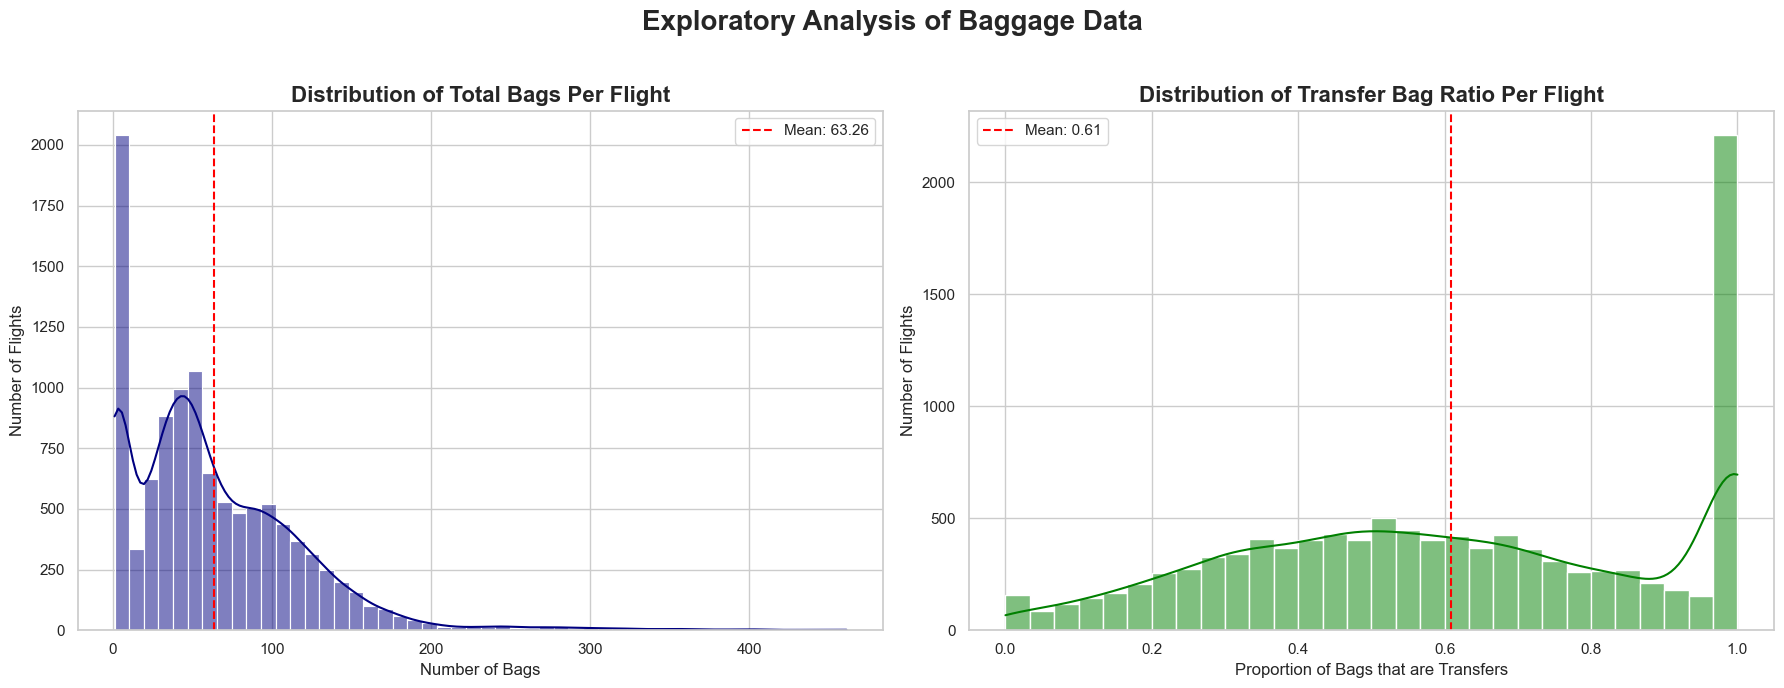

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

bag_data = pd.read_csv('Bag Level Data.csv')

flight_identifier_cols = [
    'company_id', 'flight_number', 'scheduled_departure_date_local',
    'scheduled_departure_station_code', 'scheduled_arrival_station_code'
]

flight_bags = bag_data.groupby(flight_identifier_cols).agg(
    total_bags=('bag_tag_unique_number', 'count'),
    transfer_bags=('bag_type', lambda x: (x == 'Transfer').sum())
).reset_index()

flight_bags['transfer_bag_ratio'] = 0.0
mask = flight_bags['total_bags'] > 0
flight_bags.loc[mask, 'transfer_bag_ratio'] = flight_bags.loc[mask, 'transfer_bags'] / flight_bags.loc[mask, 'total_bags']

fig, axs = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Exploratory Analysis of Baggage Data', fontsize=20, fontweight='bold')
sns.set_style('whitegrid')

sns.histplot(data=flight_bags, x='total_bags', ax=axs[0], bins=50, kde=True, color='navy')
mean_bags = flight_bags['total_bags'].mean()
axs[0].axvline(mean_bags, color='red', linestyle='--', label=f'Mean: {mean_bags:.2f}')
axs[0].set_title('Distribution of Total Bags Per Flight', fontsize=16, fontweight='bold')
axs[0].set_xlabel('Number of Bags', fontsize=12)
axs[0].set_ylabel('Number of Flights', fontsize=12)
axs[0].legend()

sns.histplot(data=flight_bags, x='transfer_bag_ratio', ax=axs[1], bins=30, kde=True, color='green')
mean_ratio = flight_bags['transfer_bag_ratio'].mean()
axs[1].axvline(mean_ratio, color='red', linestyle='--', label=f'Mean: {mean_ratio:.2f}')
axs[1].set_title('Distribution of Transfer Bag Ratio Per Flight', fontsize=16, fontweight='bold')
axs[1].set_xlabel('Proportion of Bags that are Transfers', fontsize=12)
axs[1].set_ylabel('Number of Flights', fontsize=12)
axs[1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



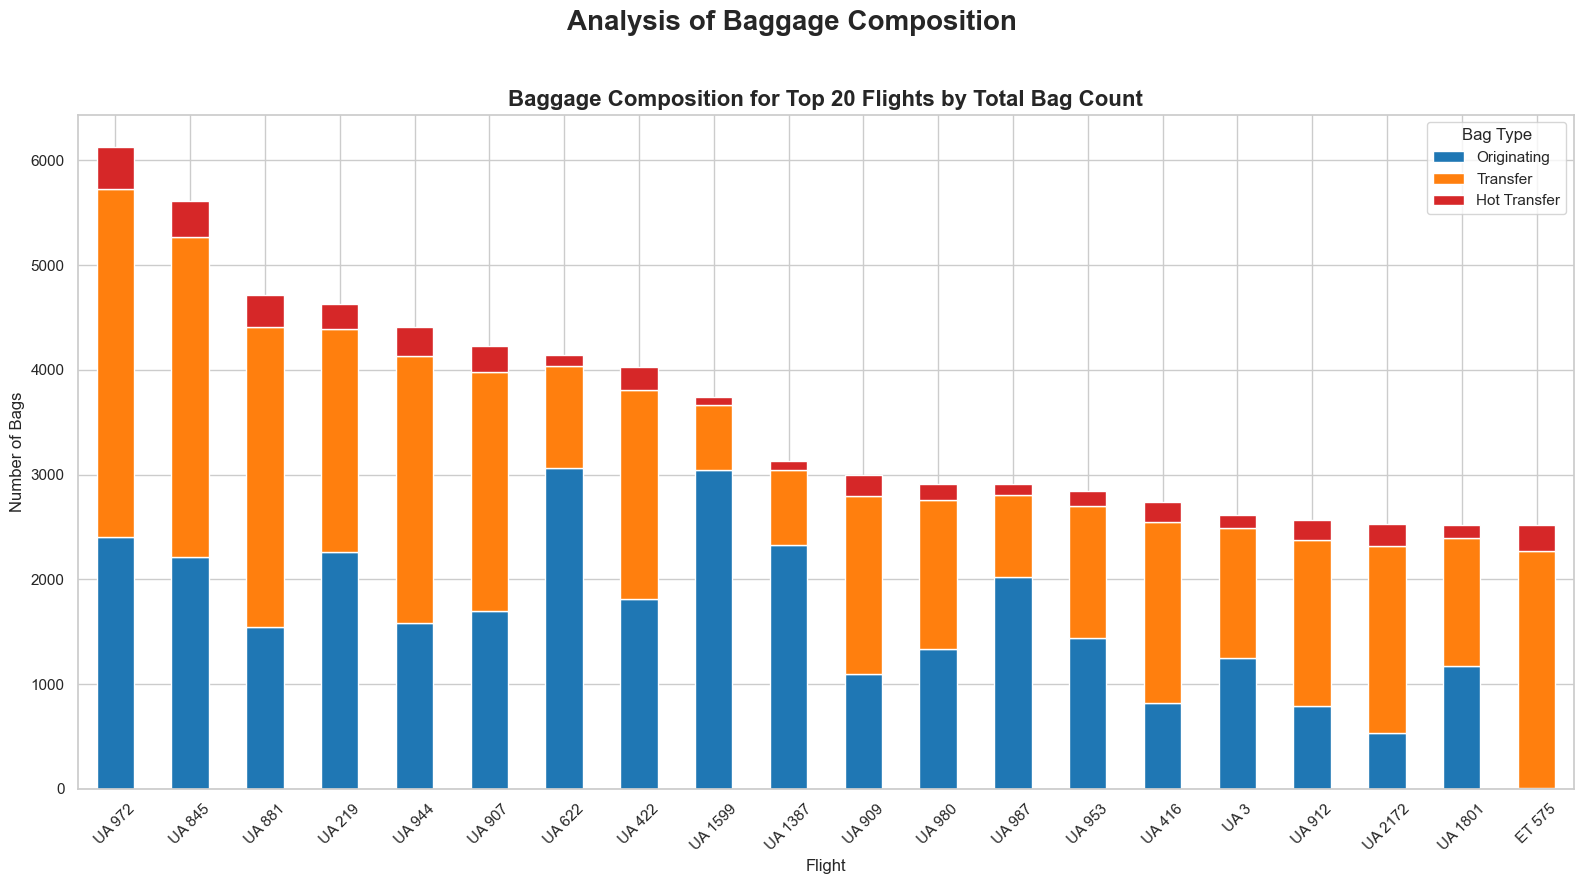

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

bag_data = pd.read_csv('Bag Level Data.csv')

flight_identifier_cols = [
    'company_id', 'flight_number', 'scheduled_departure_date_local'
]

bag_data['flight_label'] = bag_data['company_id'] + ' ' + bag_data['flight_number'].astype(str)

is_transfer = bag_data['bag_type'] == 'Transfer'
is_hot_transfer = (is_transfer) & (np.random.rand(len(bag_data)) < 0.1)

bag_data['bag_category'] = 'Originating'
bag_data.loc[is_transfer, 'bag_category'] = 'Transfer'
bag_data.loc[is_hot_transfer, 'bag_category'] = 'Hot Transfer'

flight_bag_composition = bag_data.groupby(['flight_label', 'bag_category'])['bag_tag_unique_number'].count().unstack(fill_value=0)

for col in ['Originating', 'Transfer', 'Hot Transfer']:
    if col not in flight_bag_composition.columns:
        flight_bag_composition[col] = 0

flight_bag_composition['total_bags'] = flight_bag_composition.sum(axis=1)
flight_bag_composition = flight_bag_composition.sort_values(by='total_bags', ascending=False)

fig, ax = plt.subplots(figsize=(16, 9))
fig.suptitle('Analysis of Baggage Composition', fontsize=20, fontweight='bold')
sns.set_style('whitegrid')

top_20_flights = flight_bag_composition.head(20)
top_20_flights[['Originating', 'Transfer', 'Hot Transfer']].plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=['#1f77b4', '#ff7f0e', '#d62728']
)
ax.set_title('Baggage Composition for Top 20 Flights by Total Bag Count', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Bags', fontsize=12)
ax.set_xlabel('Flight', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.legend(title='Bag Type')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

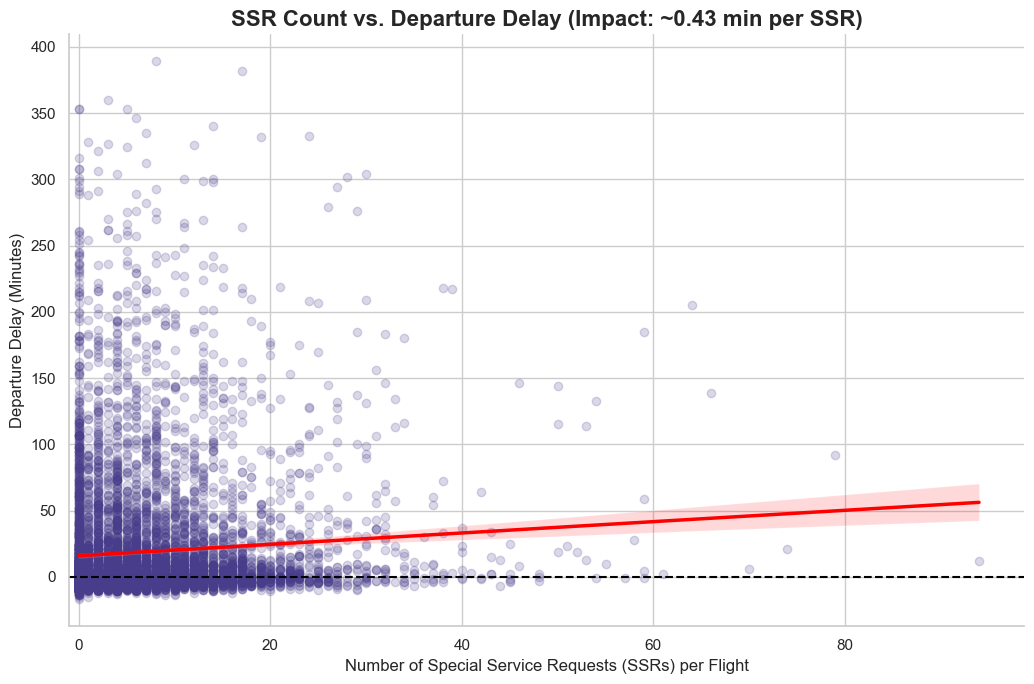

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

flight_data = pd.read_csv('Flight Level Data.csv')
pnr_flight_data = pd.read_csv('PNR Flight Level Data.csv')
pnr_remarks_data = pd.read_csv('PNR Remark Level Data.csv')

def create_flight_key(df):
    date_col = 'scheduled_departure_date_local'
    df[date_col] = pd.to_datetime(df[date_col]).dt.date
    return (df[date_col].astype(str) + '_' +
            df['flight_number'].astype(str) + '_' +
            df['scheduled_departure_station_code'].astype(str))

flight_data['flight_key'] = create_flight_key(flight_data)
pnr_flight_data['flight_key'] = create_flight_key(pnr_flight_data)

flight_data['scheduled_departure_datetime_local'] = pd.to_datetime(flight_data['scheduled_departure_datetime_local'], errors='coerce')
flight_data['actual_departure_datetime_local'] = pd.to_datetime(flight_data['actual_departure_datetime_local'], errors='coerce')
flight_data.dropna(subset=['scheduled_departure_datetime_local', 'actual_departure_datetime_local'], inplace=True)
flight_data['delay'] = (flight_data['actual_departure_datetime_local'] - flight_data['scheduled_departure_datetime_local']).dt.total_seconds() / 60

pnr_to_flight_map = pnr_flight_data[['record_locator', 'flight_key']].drop_duplicates()
remarks_with_key = pd.merge(pnr_remarks_data, pnr_to_flight_map, on='record_locator', how='left')
ssr_counts = remarks_with_key.groupby('flight_key').size().reset_index(name='ssr_count')

merged_df_ssr = pd.merge(flight_data, ssr_counts, on='flight_key', how='left')

merged_df_ssr['ssr_count'] = merged_df_ssr['ssr_count'].fillna(0)

plot_df_ssr = merged_df_ssr[merged_df_ssr['delay'].between(-60, 400)].dropna(subset=['ssr_count', 'delay'])
slope, _, _, _, _ = linregress(plot_df_ssr['ssr_count'], plot_df_ssr['delay'])

sns.lmplot(data=plot_df_ssr, x='ssr_count', y='delay', height=7, aspect=1.5,
           scatter_kws={'alpha': 0.2, 'color': 'darkslateblue'},
           line_kws={'color': 'red', 'linewidth': 2.5})

plt.title(f'SSR Count vs. Departure Delay (Impact: ~{slope:.2f} min per SSR)', fontsize=16, fontweight='bold')
plt.xlabel('Number of Special Service Requests (SSRs) per Flight', fontsize=12)
plt.ylabel('Departure Delay (Minutes)', fontsize=12)
plt.axhline(0, color='black', linestyle='--')
plt.xlim(left=-1)
plt.tight_layout()
plt.show()

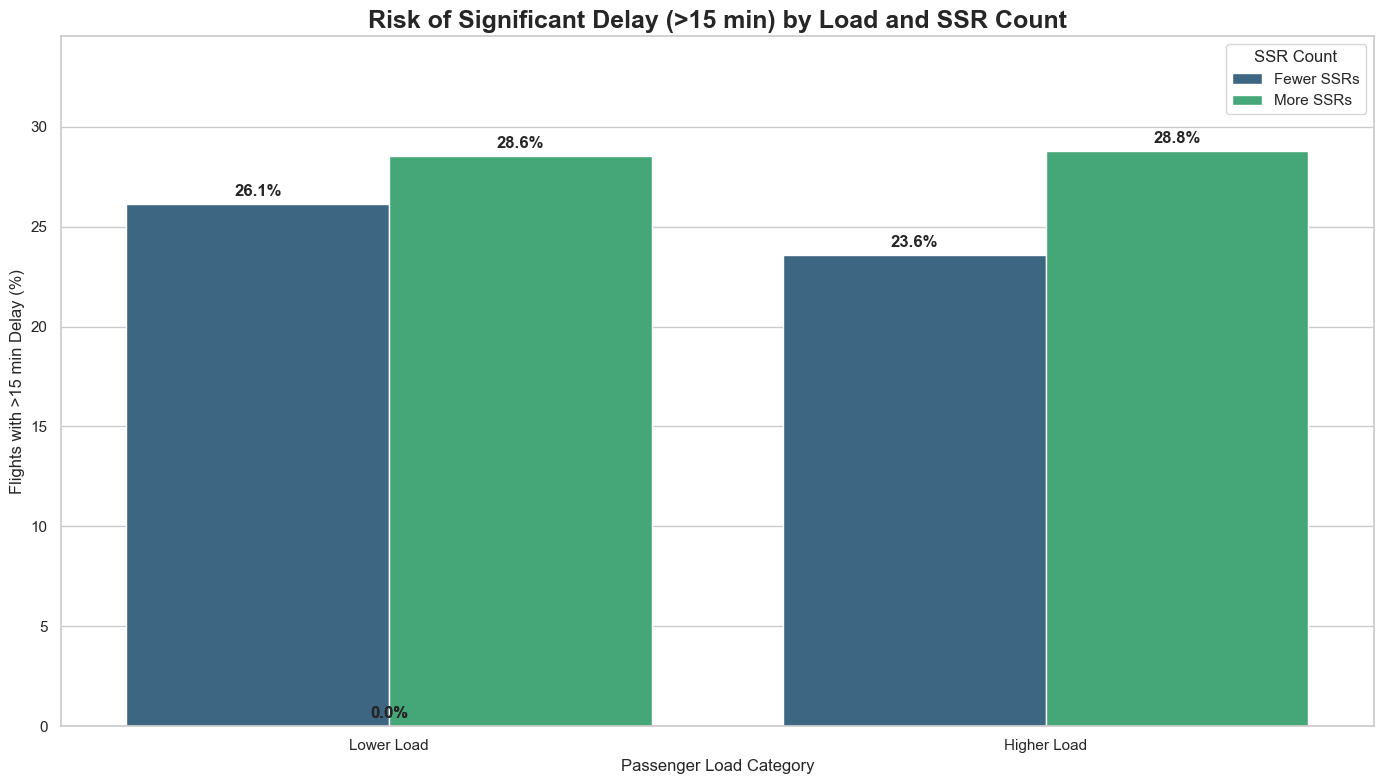

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

flight_data = pd.read_csv('Flight Level Data.csv')
pnr_flight_data = pd.read_csv('PNR Flight Level Data.csv')
pnr_remarks_data = pd.read_csv('PNR Remark Level Data.csv')

def create_flight_key(df):
    date_col = 'scheduled_departure_date_local'
    df[date_col] = pd.to_datetime(df[date_col]).dt.date
    return (df[date_col].astype(str) + '_' +
            df['flight_number'].astype(str) + '_' +
            df['scheduled_departure_station_code'].astype(str))

for df_ in [flight_data, pnr_flight_data]:
    df_['flight_key'] = create_flight_key(df_)

flight_data['scheduled_departure_datetime_local'] = pd.to_datetime(flight_data['scheduled_departure_datetime_local'], errors='coerce')
flight_data['actual_departure_datetime_local'] = pd.to_datetime(flight_data['actual_departure_datetime_local'], errors='coerce')
flight_data.dropna(subset=['scheduled_departure_datetime_local', 'actual_departure_datetime_local'], inplace=True)
flight_data['departure_delay_minutes'] = (flight_data['actual_departure_datetime_local'] - flight_data['scheduled_departure_datetime_local']).dt.total_seconds() / 60

pax_counts = pnr_flight_data.groupby('flight_key')['total_pax'].sum().reset_index()
analysis_df = pd.merge(flight_data, pax_counts, on='flight_key', how='left')
analysis_df['load_factor'] = analysis_df['total_pax'] / analysis_df['total_seats']

pnr_to_flight_map = pnr_flight_data[['record_locator', 'flight_key']].drop_duplicates()
remarks_with_key = pd.merge(pnr_remarks_data, pnr_to_flight_map, on='record_locator', how='left')
ssr_counts = remarks_with_key.groupby('flight_key').size().reset_index(name='ssr_count')
analysis_df = pd.merge(analysis_df, ssr_counts, on='flight_key', how='left')
analysis_df['ssr_count'] = analysis_df['ssr_count'].fillna(0)
analysis_df.dropna(subset=['load_factor', 'ssr_count', 'departure_delay_minutes'], inplace=True)

analysis_df['load_category'] = pd.qcut(analysis_df['load_factor'], 2, labels=['Lower Load', 'Higher Load'])
ssr_median = analysis_df['ssr_count'].median()
analysis_df['ssr_category'] = analysis_df['ssr_count'].apply(lambda x: 'More SSRs' if x > ssr_median else 'Fewer SSRs')
analysis_df['is_significantly_delayed'] = analysis_df['departure_delay_minutes'] > 15

risk_analysis = analysis_df.groupby(['load_category', 'ssr_category'], observed=True)['is_significantly_delayed'].mean().reset_index()
risk_analysis['significant_delay_pct'] = risk_analysis['is_significantly_delayed'] * 100

plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

ax = sns.barplot(
    data=risk_analysis,
    x='load_category',
    y='significant_delay_pct',
    hue='ssr_category',
    palette='viridis'
)

plt.title('Risk of Significant Delay (>15 min) by Load and SSR Count', fontsize=18, fontweight='bold')
plt.xlabel('Passenger Load Category', fontsize=12)
plt.ylabel('Flights with >15 min Delay (%)', fontsize=12)
plt.legend(title='SSR Count')
plt.ylim(0, risk_analysis['significant_delay_pct'].max() * 1.2)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontweight='bold')

plt.tight_layout()
plt.show()